### Best Model Architecture


In [1]:
import time
import math
notebook_start = time.time()

#### Init Libraries

In [2]:
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
import os

#### Load Dataset and split into Features and Label

In [3]:
#load data
df=pd.read_csv("breast-cancer-wisconsin-data/data.csv")
#drop irelevent columns for the classification
df = df.drop(columns=['Unnamed: 32', 'id'])
# rearange the data for X - featuers and Y leabels 
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

#### Encode Labels

In [4]:
le = LabelEncoder()
y = le.fit_transform(y)

#### The mapping of the labels

In [5]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'B': 0, 'M': 1}


#### Splitting the data into Train, Test and Valid datasets

In [6]:
#split the data
from sklearn.model_selection import train_test_split
XData_train_val, XData_test, ydata_train_val, ydata_test = train_test_split(X, y, test_size=0.2, random_state=0)
XData_train, XData_val, ydata_train, ydata_val = train_test_split(XData_train_val, ydata_train_val, test_size=0.2, random_state=0)

#### Scale the data

In [7]:
scaler = RobustScaler()
X_train = scaler.fit_transform(XData_train)
X_test = scaler.transform(XData_test)
X_val = scaler.transform(XData_val)

X_train_val = XData_train_val.values

y_train = ydata_train
y_test = ydata_test
y_val = ydata_val

y_train_val = ydata_train_val

#### Handling the imbalance between the classes

In [8]:
#handling imbalance data 
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
#the class weight is done only on the train data to impact the learning process and to evaluete beter the model proformence
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.774468085106383, 1: 1.4108527131782946}

as predicted the minorty class 'M'=1 gets higher weight of 1.368

### Neural Networks

##### Init Libraries

In [9]:
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.regularizers import l1, l2
#from keras.layers import Dropout, Flatten, BatchNormalization
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics
from keras import callbacks
from keras import utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf

##### Function Helpers

In [10]:
def model_result(model, X, y, dataset_name):
    print('================================================================================')
    print(f'Evaluation Report for Model: {model.name} on {dataset_name}')

    # accuracy
    result = model.evaluate(X, y, verbose=0)        
    print(f'Loss Value: {result[0]:.3f}, Accuracy: {result[1]*100:.3f}%')

    # confusion matrix
    y_prob = model.predict(X, verbose=0)
    y_pred = np.round(y_prob).astype(int)    
    cm = confusion_matrix(y, y_pred)    
    #sns.heatmap(cm,annot=True)
    cm_disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    cm_disp.plot()
    plt.title(f'{model.name} Confusion Matrix on {dataset_name} Dataset')
    plt.show()

    # classification report
    report = classification_report(y, y_pred, target_names=le.classes_)
    print(report)

    print('Model Summary:')
    print(model.summary())
    print('================================================================================')

In [11]:
def model_history(history, param=None):
    plt.figure(figsize=(15,6))

    val_loss_min_pos = np.argmin(history.history['val_loss'])

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    if param is None:
        plt.title('Train and Validation Loss')
    else:
        plt.title(f'Train and Validation Loss on {param}')

    plt.plot(val_loss_min_pos, history.history['val_loss'][val_loss_min_pos], 'r*', label='Min Validation Loss')
    plt.text(val_loss_min_pos, history.history['val_loss'][val_loss_min_pos], f'({val_loss_min_pos}, {history.history['val_loss'][val_loss_min_pos]:.3f})', va='bottom')
    plt.legend()

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(val_loss_min_pos, history.history['val_accuracy'][val_loss_min_pos], 'r*', label='Validation Accuracy @ Min Validation Loss')
    plt.text(val_loss_min_pos, history.history['val_accuracy'][val_loss_min_pos], f'({val_loss_min_pos}, {history.history['val_accuracy'][val_loss_min_pos]:.3f})', va='bottom')

    if param is None:
        plt.title('Train and Validation Accuracy')
    else:
        plt.title(f'Train and Validation Accuracy on {param}')
        
    plt.legend()

    plt.show()    

In [12]:
def proc_history(history):

    val_loss_min_pos = np.argmin(history.history['val_loss'])

    train_acc = history.history['accuracy'][val_loss_min_pos]
    train_loss = history.history['loss'][val_loss_min_pos]

    val_acc = history.history['val_accuracy'][val_loss_min_pos]
    val_loss = history.history['val_loss'][val_loss_min_pos]    

    val_recall = history.history['val_recall'][val_loss_min_pos]

    return {'Train Accuracy': train_acc, 'Train Loss': train_loss, 'Validation Accuracy': val_acc, 'Validation Loss': val_loss, 'Validation Recall': val_recall}

In [13]:
def model_fit(model, optimizer=optimizers.RMSprop, learning_rate=0.001, epochNum=2500, batchSize=32, en_reduce_lr=False, en_early_stopping=True, pca=False, verbose="auto", Dataset=None):      
    
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=0)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001, verbose=0)
    checkpoint_filepath = f'model_checkpoints/{model.name}_checkpoint.model.keras'
    model_checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0)
    
    callbacks_list = [model_checkpoint_callback]

    if en_reduce_lr:
        callbacks_list.append(reduce_lr)

    if en_early_stopping:
        callbacks_list.append(early_stopping)

    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy', metrics.Recall(name='recall')])
    if Dataset is None:
        history = model.fit(X_train, y_train, batch_size=batchSize, epochs=epochNum, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=callbacks_list, verbose=verbose)
    else:
        history = model.fit(Dataset['X_train'], Dataset['y_train'], batch_size=batchSize, epochs=epochNum, validation_data=(Dataset['X_val'], Dataset['y_val']), class_weight=class_weight_dict, callbacks=callbacks_list, verbose=verbose)

    model = models.load_model(checkpoint_filepath)

    return history, model

In [14]:
def model_kfold(xtrain, ytrain, model_base, optimizer=optimizers.RMSprop,learning_rate=0.001, epochNum=2500, batchSize=32, en_reduce_lr=False, en_early_stopping=True, verbose="auto"):
    model = models.clone_model(model_base)
    fold_k = StratifiedKFold(n_splits = 5).split(xtrain, ytrain)
    
    result_df = pd.DataFrame(columns=['k', 'Train Accuracy', 'Train Loss' , 'Validation Accuracy', 'Validation Loss',  'Validation Recall'])
    for k , (train, valid) in enumerate(fold_k):

        scaler = RobustScaler()

        X_train = scaler.fit_transform(xtrain[train])
        X_val = scaler.transform(xtrain[valid])
        
        dataset = {'X_train': X_train, 'y_train': ytrain[train], 'X_val': X_val, 'y_val': ytrain[valid]}
        model.set_weights(model_base.get_weights())

        

        history, model = model_fit(model, optimizer=optimizer, learning_rate=learning_rate, epochNum=epochNum, batchSize=batchSize, en_reduce_lr=en_reduce_lr, en_early_stopping=en_early_stopping, Dataset=dataset, verbose=verbose)    
        
        proc_data = proc_history(history)

        new_row = {'k': k, **proc_data}

        result_df.loc[len(result_df)] = new_row

    return result_df

#### Best Model - SLP - Architecture

In [15]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'SLP')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

BEST_MODEL.summary()

Model: "SLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

##### Best Model - SLP - Learning Curve

In [16]:
history, model = model_fit(BEST_MODEL, epochNum=2500, batchSize=32, verbose=0)

proc_data = proc_history(history)

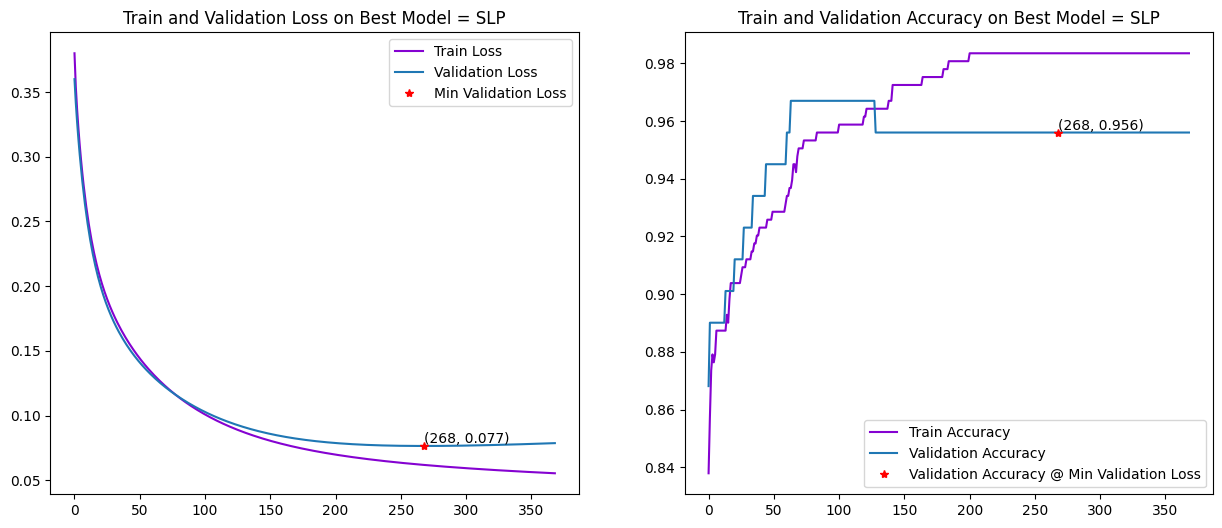

In [17]:
model_history(history, f'Best Model = SLP')

##### Best Model - SLP - Train Results

Evaluation Report for Model: SLP on Train
Loss Value: 0.063, Accuracy: 98.352%


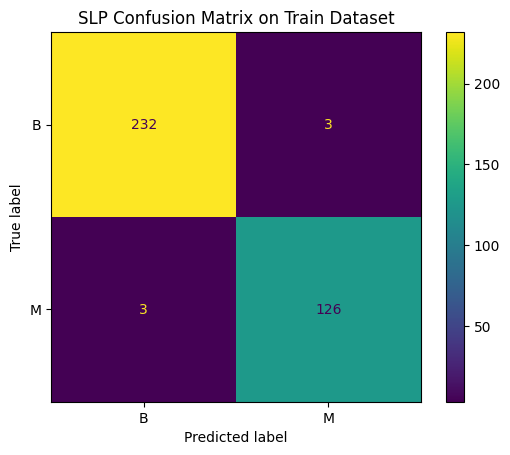

              precision    recall  f1-score   support

           B       0.99      0.99      0.99       235
           M       0.98      0.98      0.98       129

    accuracy                           0.98       364
   macro avg       0.98      0.98      0.98       364
weighted avg       0.98      0.98      0.98       364

Model Summary:


Model: "SLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64 (260.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33 (136.00 B)

None


In [18]:
model_result(model, X_train, y_train, 'Train')

##### Best Model - SLP - Validation Results

Evaluation Report for Model: SLP on Validation
Loss Value: 0.077, Accuracy: 95.604%


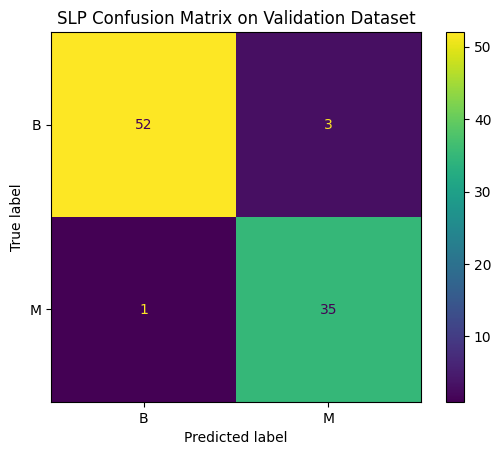

              precision    recall  f1-score   support

           B       0.98      0.95      0.96        55
           M       0.92      0.97      0.95        36

    accuracy                           0.96        91
   macro avg       0.95      0.96      0.95        91
weighted avg       0.96      0.96      0.96        91

Model Summary:


Model: "SLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64 (260.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33 (136.00 B)

None


In [19]:
model_result(model, X_val, y_val, 'Validation')

##### Best Model - SLP - Test Results

Evaluation Report for Model: SLP on Test
Loss Value: 0.134, Accuracy: 93.860%


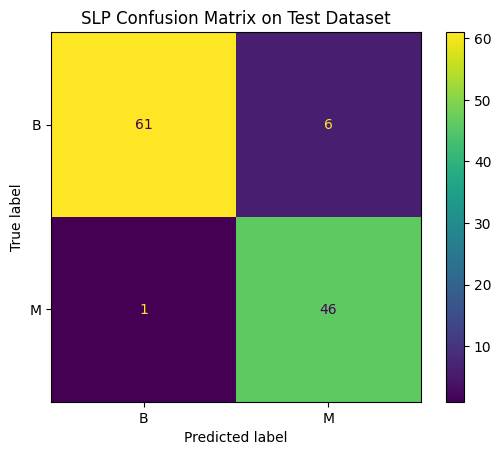

              precision    recall  f1-score   support

           B       0.98      0.91      0.95        67
           M       0.88      0.98      0.93        47

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.94       114
weighted avg       0.94      0.94      0.94       114

Model Summary:


Model: "SLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64 (260.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33 (136.00 B)

None


In [20]:
model_result(model, X_test, y_test, 'Test')

### Notebook End

In [21]:
notebook_end = time.time()
notebook_elapsed = notebook_end-notebook_start
print('Finished Notebook Run!')
print(f'Elapsed Run Time: {math.floor(notebook_elapsed/3600)} (h), {math.floor(notebook_elapsed%3600/60)} (m), {math.floor(notebook_elapsed%60)} (s)')

Finished Notebook Run!
Elapsed Run Time: 0 (h), 0 (m), 31 (s)
